<h1><center>CMPE 462 - Quiz 4&5 <br>Implementing a Regression Tree<br>Due: May 5, 2020, 23:59</center></h1>

# Introduction

Decision trees can learn rules to map features to both continous and discrete outputs. In this quiz, you will consider the continous case and implement a regression tree to predict house prices in Boston. You will also conduct small data analysis and evaluation procedures. This notebook will guide you through.

## (10 pts) Task 1: Dataset 

Run the cells below to load Boston house prices dataset using `scikit-learn`. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset). **Please use the train and test matrices we prepared for you :)**

In [1]:
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
boston = load_boston()
X_y = np.column_stack([boston['data'], boston['target']])
np.random.seed(1)
np.random.shuffle(X_y)
X, y = X_y[:,:-1], X_y[:,-1]
X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]
del X, y, X_y

**(10 pts)** Unlike the dataset in Project 1, Boston dataset is high-dimensional and we cannot observe the relations between all features and the output with a single scatter plot. What we can do is to visualize the correlations between both features and house prices using a heatmap. So, stack the features and the outputs in a single matrix and compute correlation between all pairs of columns. Visualize the correlation coefficient matrix as a heatmap, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset. You can check out `corrcoef` and `heatmap` functions from `numpy` and `seaborn` libraries, respectively. You can use diverging color palette to emphasize both positive and negative correlations.

Do you observe strong correlations between any pair of features or certain features and house price? 

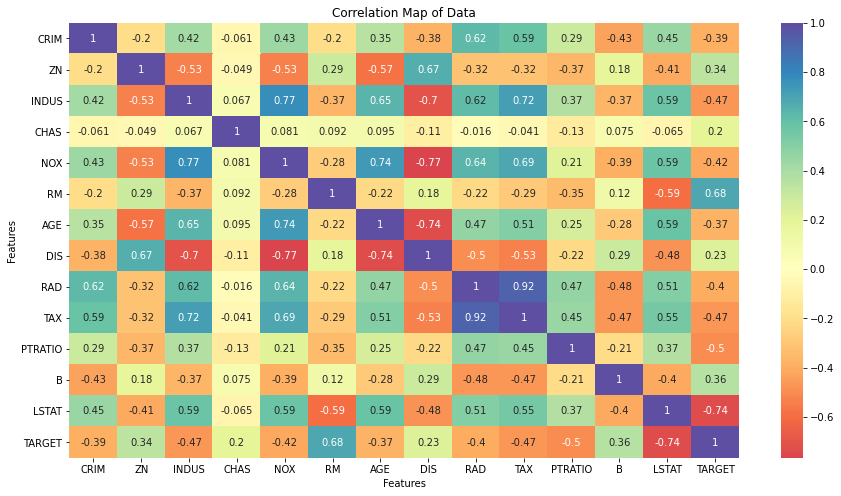

Most correlated is LSTAT
Least correlated is CHAS


In [3]:
fn = np.append(boston.feature_names, "TARGET")
stacked = np.column_stack([X_train,y_train])
corr = np.corrcoef(stacked.T)
plt.figure(figsize = (15,8))
sns.heatmap(corr, xticklabels=fn, yticklabels=fn, center=0,cmap = "Spectral", annot=True, annot_kws={'size' : 10})
plt.xlabel("Features")
plt.ylabel("Features")
plt.title("Correlation Map of Data")
plt.show()
most = np.argmax(np.abs(corr[-1,:-1]))
least = np.argmin(np.abs(corr[-1,:-1]))
print ("Most correlated is {}".format(fn[most]))
print ("Least correlated is {}".format(fn[least]))
# LSTAT, RM CAN BE A GOOD EXAMPLE
# CHAS is not good

## (80 pts) Task 2: Regression Tree


**(15 pts)** Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We stick to lecture notes and use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

When you implement $RSS$, pick the most correlated and least correlated feature with the output prices according to previous step. Note that correlation can be both positive and negative! For both features, compute $RSS$ for every possible split threshold and plot thresholds versus RSS scores.

Do two features display different characteristics?

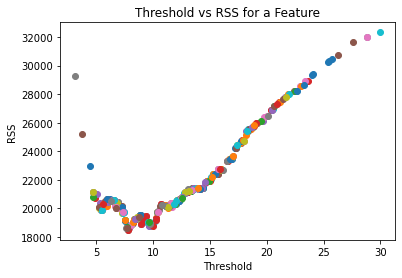

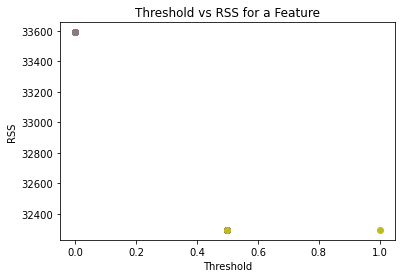

In [4]:
def rss(th, vec, y):               # calculate rss value of given feature, with respect to given threshold using y as label
    score = 0
    left_m, right_m = 0,0
    left = y[vec < th]              # getting left side values
    right = y[vec >= th]            # getting right side values
    left_m, right_m = np.mean(left) if len(left) > 0 else 0, np.mean(right) if len(right) > 0 else 0
    score = np.sum((y[vec < th] - left_m)**2) + np.sum((y[vec >= th] - right_m)**2)      ## rss sum
    return score

def plot_th_vs_rss(vec, y):            # plotting each point against rss values
    plt.figure()
    plt.xlabel("Threshold")
    plt.ylabel("RSS")
    plt.title("Threshold vs RSS for a Feature")
    for i in range(0, len(vec)-1):
        th = (vec[i]+vec[i+1])/2
        plt.scatter(th,rss(th,  vec, y))
    plt.show()

plot_th_vs_rss(X_train[:, most], y_train)
plot_th_vs_rss(X_train[:, least],y_train)

**(45 pts)** Now implement the training procedure of a regression tree using $RSS$ as split criteria. Build a rule tree recursively by traversing all features and considering each split threshold to find the optimum split, at every node.

You are free to implement training procedure as a standalone function or part of a class, but in any case use maximum depth as the stopping condition.

In [5]:
class Node:
    def __init__(self, data , depth):       # recursion constructor
        self.feature = None
        self.data = data
        self.depth = depth
        if depth >0 and len(self.data) > 1:       # if depth is not reached and there is at least 2 data points
            self.findOptimalSplit()               # split those points
     
    def findOptimalSplit(self):
        rss_scores, th_values = [], []
        for i in range(np.shape(self.data)[1]-1):                              ## for all features in data
            th, rss_sc = self.findOptimalThreshold(self.data[:,i], self.data[:,-1])     # get optimal threshold for each feature
            th_values.append(th)
            rss_scores.append(rss_sc)
        self.feature = np.argmin(rss_scores)                                    ## feature with minimal ratio
        self.threshold = th_values[self.feature]                               ## assign optimal threhold
        self.split()
    
    def findOptimalThreshold(self, vec, y):
        rss_scores = []
        for i in range(len(vec)-1):                          # for all data points
            rss_scores.append(rss((vec[i] + vec[i+1])/2, vec, y))        # calculate rss score
        ind = np.argmin(rss_scores)                                       # minimal rss is the one we look for
        return (vec[ind] + vec[ind+1])/2 , rss_scores[ind]
    
    def split(self):
        vec = self.data[:,self.feature]                      # get feature matrix
        rows_l, rows_r = [], []
        for i in range(len(vec)):                            # for all points in vector
            if vec[i] < self.threshold:                      # split into two
                rows_l.append(i) 
            else:
                rows_r.append(i)
        self.left_node = Node(self.data[rows_l, :], self.depth -1)       # start growing tree
        self.right_node = Node(self.data[rows_r, :], self.depth - 1)      # start growing tree


**(15 pts)** Having implemented the regression tree, now write a procedure to predict test features. Given a sample, this procedure should follow the rules learned during the training to arrive at a leaf and predict the output as the mean output of the arrived leaf samples. 

If you have implemented a regression tree class, you can insert this procedure as a class function 

In [6]:
from sklearn.metrics import r2_score

def predict(node, point):                            # predicts given point from given tree
    if node.feature != None:
        if point[node.feature] < node.threshold:
            return predict(node.left_node, point)
        else:
            return predict(node.right_node, point)
    return np.mean(node.data[:,-1])

def evaluate(X, y, tree):                           # predicts all points given and returns an r2_score
    results = []
    for i in range(len(y)):
        res = predict(tree, X[i,:])
        results.append(res)
    return r2_score(y, results)

**(5 pts)** Train your model using a max depth of 3 and visualize the resulting tree. You can use an external tool such as draw.io or LaTeX for drawing. Annotate the nodes with split columns and thresholds. You can view the tree in this [link](https://scikit-learn.org/stable/modules/tree.html#tree) as an example. 

  LSTAT 7.8100000000000005
   RM 7.4435
     DIS 1.48415
        91.08596571428572
        60.719626999999996
     CRIM 2.46882
        60.482206118012414
        86.34407
   LSTAT 14.844999999999999
     RM 6.5465
        64.99042128787879
        63.79181411564626
     NOX 0.6585
        68.19956522959183
        79.28662914062501


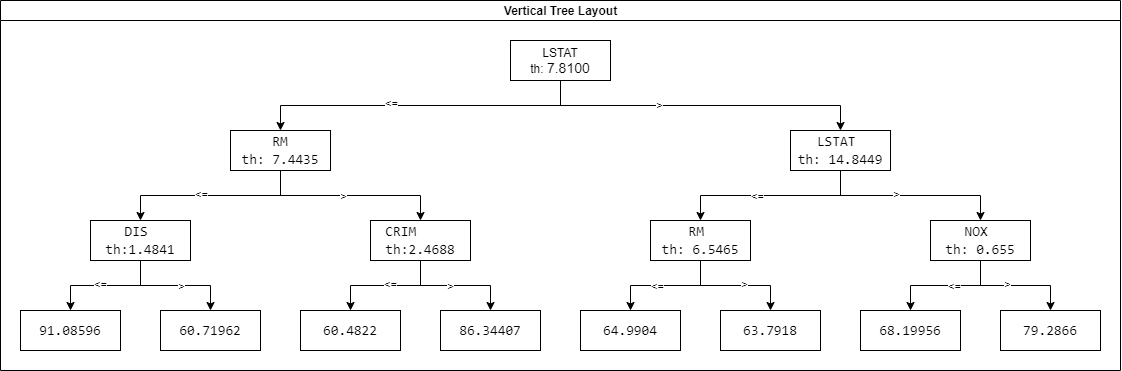

In [7]:
def printree(node, end, names):                                  # prints  tree as dfs ( recursive )
    print(end, names[node.feature], node.threshold)
    if node.left_node.feature != None:
        printree(node.left_node,  2*end, names)
        
    if node.right_node.feature != None:
        printree(node.right_node, end*2, names)
    
    if  node.right_node.feature == None and node.left_node.feature == None:
        print(end + end + str(np.mean(node.left_node.data)))
        print(end + end + str(np.mean(node.right_node.data)))
        
root = Node(data = stacked, depth = 3)    
printree(root, " ", boston.feature_names)

from IPython.display import Image                             # tree image for depth 3
display(Image("tree.png"))

## **(10 pts)** Task 3: Evaluation

**(5 pts)** Now is time to pick the best maximum depth and observe your tree's performance! Implement a 5-fold cross validation procedure to experiment with maximum depths from 3 to 10. Report mean and standard deviation for each depth and pick the best one. For comparison you can use $R^2$, which is a metric frequently used to evaluate regression models. You can use `r2_score` function of `scikit-learn` and read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

In [8]:
def kCrossValid(k, X, y): 
    best_depth = [0,0]                   
    stack_xy = np.column_stack([X , y])           
    np.random.seed(17)                                   ## random shuffle seed 17, for better results
    np.random.shuffle(stack_xy)                          ## shuffling
    foldN = int(np.ceil(len(stack_xy) / k))        
    for dep in range(3,11):
        depth_reset = []
        for test in range(k):
            train_data = np.delete(stack_xy, np.arange(test*foldN, (test+1)*foldN), axis=0)    # train matrix preparation
            test_data = stack_xy[np.arange(test*foldN, (test+1)*foldN),:]                      # test matrix preparation
            result = evaluate(test_data[:,:-1], test_data[:,-1], Node(train_data, dep))        # getting result
            depth_reset.append(result)                                                      # adding result to list
        t_mean, t_std = np.mean(depth_reset), np.std(depth_reset)                           # mean and std calculation
        if best_depth[1] <= t_mean - t_std:                                        # finding best values
            best_depth[0], best_depth[1] =  dep, t_mean - t_std
        print("Depth: {:<5}  -  Mean: {:<10} -  Std: {:<10}".format(dep, "{:.4f}".format(t_mean),"{:.4f}".format(t_std)))
    return best_depth[0]
best_one_chosen = kCrossValid(5, X_train, y_train)

Depth: 3      -  Mean: 0.6433     -  Std: 0.1404    
Depth: 4      -  Mean: 0.7408     -  Std: 0.1018    
Depth: 5      -  Mean: 0.7635     -  Std: 0.1075    
Depth: 6      -  Mean: 0.7668     -  Std: 0.0930    
Depth: 7      -  Mean: 0.7671     -  Std: 0.0866    
Depth: 8      -  Mean: 0.7722     -  Std: 0.0765    
Depth: 9      -  Mean: 0.7659     -  Std: 0.0795    
Depth: 10     -  Mean: 0.7633     -  Std: 0.0854    


**(5 pts)** To conclude, train your tree one last time on the whole training data with the depth you picked in the previous section. Generate predictions on both training and test sets and report $R^2$ scores.

In [9]:
print(best_one_chosen)
root = Node(data = stacked, depth = best_one_chosen)    

print("R2 Score TRAIN:", evaluate(X_train, y_train, root))
print("R2 Score TEST:", evaluate(X_test, y_test, root))

8
R2 Score TRAIN: 0.9765198981466712
R2 Score TEST: 0.8400000289436316
